<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Import-of-all-required-packages" data-toc-modified-id="1.-Import-of-all-required-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Import of all required packages</a></span></li><li><span><a href="#2.-Define-the-Evaluation-Function-and-the-Local-Search-Function" data-toc-modified-id="2.-Define-the-Evaluation-Function-and-the-Local-Search-Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Define the Evaluation Function and the Local Search Function</a></span></li><li><span><a href="#3.-Run-the-MOEAs-to-plot-the-Pareto-fronts-and-routes" data-toc-modified-id="3.-Run-the-MOEAs-to-plot-the-Pareto-fronts-and-routes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Run the MOEAs to plot the Pareto fronts and routes</a></span><ul class="toc-item"><li><span><a href="#3.1-Load-the-already-calculated-result-dataset-to-skip-the-long-runtime" data-toc-modified-id="3.1-Load-the-already-calculated-result-dataset-to-skip-the-long-runtime-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>3.1 Load the already calculated result dataset to skip the long runtime</a></span></li><li><span><a href="#3.2-Run-the-algorithm-(skip)" data-toc-modified-id="3.2-Run-the-algorithm-(skip)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>3.2 Run the algorithm (skip)</a></span></li><li><span><a href="#3.3-Create-DataFrames-to-plot-the-routes-(skip)" data-toc-modified-id="3.3-Create-DataFrames-to-plot-the-routes-(skip)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>3.3 Create DataFrames to plot the routes (skip)</a></span></li><li><span><a href="#3.4-Plot-the-Pareto-fronts" data-toc-modified-id="3.4-Plot-the-Pareto-fronts-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>3.4 Plot the Pareto fronts</a></span></li><li><span><a href="#3.5-Plot-the-routes-on-a-world-map" data-toc-modified-id="3.5-Plot-the-routes-on-a-world-map-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>3.5 Plot the routes on a world map</a></span></li><li><span><a href="#3.6-Explorative-Data-analysis" data-toc-modified-id="3.6-Explorative-Data-analysis-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>3.6 Explorative Data analysis</a></span></li></ul></li><li><span><a href="#4.-Experimenter" data-toc-modified-id="4.-Experimenter-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Experimenter</a></span><ul class="toc-item"><li><span><a href="#4.1-Run-the-experimenter-(skip)" data-toc-modified-id="4.1-Run-the-experimenter-(skip)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>4.1 Run the experimenter (skip)</a></span></li><li><span><a href="#4.2-Wilcoxon-Signed-Rank-Test" data-toc-modified-id="4.2-Wilcoxon-Signed-Rank-Test-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>4.2 Wilcoxon Signed-Rank Test</a></span></li><li><span><a href="#4.3-Sample-Size" data-toc-modified-id="4.3-Sample-Size-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>4.3 Sample Size</a></span></li></ul></li></ul></div>

Three-objective TSP with multiple traveling modalities

Author: Kevin Gräf <br>
Date: 10 August 2020

# 1. Import of all required packages

In [ ]:
# For better navigation in the jupyter notebook
pip install jupyter_contrib_nbextensions jupyter_nbextensions_configurator
# Go back to the Jupyter main tab in your browser
# Go to the 'Nbextensions' tab and activate 'Table of Contents'

In [1]:
# pip install platypus-opt
from platypus import *         # the MOEA framework

# pip install pandas
import pandas as pd            # for DataFrames

# pip install xlrd
import xlrd                    # for import/export from Excel

# pip install matplotlib.pyplot
import matplotlib.pyplot as plt

# pip install numpy
import numpy as np

# pip install scipy
import scipy.stats as stats    # for statistical testing
from scipy.spatial.distance import pdist, squareform

# pip install plotly
import plotly.graph_objects as go # for plotting routes

# pip install geopy
from geopy.geocoders import Nominatim # for retrieving longitude and latitude data of cities

# Python standard libraries, should be already installed
import pickle                  # To store and retrieve result variables
import random
import math

# Required if run in Google Colab
#from google.colab import files, output
#import io

In [2]:
# Importing the distance matrices from Excel and convert them into numpy arrays
data = pd.read_excel("MOTSP_12_real.xlsx",sheet_name=[0,1,2,3,4,5])

time_bus = data[0]
time_bus = time_bus.set_index("time_bus")
time_bus2 = time_bus
time_bus = time_bus.to_numpy()

time_flight = data[1]
time_flight = time_flight.set_index("time_flight")
time_flight = time_flight.to_numpy()

carbon_bus = data[2]
carbon_bus = carbon_bus.set_index("emission_bus")
carbon_bus = carbon_bus.to_numpy()

carbon_flight = data[3]
carbon_flight = carbon_flight.set_index("emission_flight")
carbon_flight = carbon_flight.to_numpy()

cost_bus = data[4]
cost_bus = cost_bus.set_index("cost_bus")
city_names = list(cost_bus[0:0]) # Store a list of city names to reference later from the route
print(city_names)
cost_bus = cost_bus.to_numpy()

cost_flight = data[5]
cost_flight = cost_flight.set_index("cost_flight")
cost_flight = cost_flight.to_numpy()

city_list = list(np.arange(1,len(cost_bus)))
print(city_list)

['Amsterdam', 'Berlin', 'Brussels', 'Copenhagen', 'Lisbon', 'London', 'Madrid', 'Paris', 'Prague', 'Rome', 'Vienna', 'Warsaw']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


# 2. Define the Evaluation Function and the Local Search Function 

In [3]:
# Function to measure the fitness of the routes
def fitness(route,borf):
    em = 0
    time = 0
    cost = 0
    for i in range(len(route)-1):
        if borf[i] == 1: # If from i to j by bus
            em += carbon_bus[route[i]][route[(i+1)%len(route)]] 
            time += time_bus[route[i]][route[(i+1)%len(route)]]
            cost += cost_bus[route[i]][route[(i+1)%len(route)]]
        if borf[i] == 0: # If by plane
            em += carbon_flight[route[i]][route[(i+1)%len(route)]]
            time += time_flight[route[i]][route[(i+1)%len(route)]]
            cost += cost_flight[route[i]][route[(i+1)%len(route)]]
    return cost, time, em

# Local search function to optimize the routes passed by the Platypus framework
def two_opt(vars):
    route = [0] + vars[0] + [0] # Always start and end at node 0 (hometown)
    borf = vars[1]
    fit = fitness(route,borf)
    for i in range(1,len(route)-3):
        for j in range(i+2,len(route)-1):
            if borf[i] == 1 and borf[j] == 1: # If bus is taken on vertex1 and vertex2
                fit1 = sum([carbon_bus[route[i]][route[i+1]], carbon_bus[route[j]][route[j+1]],
                              time_bus[route[i]][route[i+1]],   time_bus[route[j]][route[j+1]],
                              cost_bus[route[i]][route[i+1]],   cost_bus[route[j]][route[j+1]]])     
            if borf[i] == 1 and borf[j] == 0: # If bus is taken on vertex1 and flight on vertex2
                fit1 = sum([carbon_bus[route[i]][route[i+1]], carbon_flight[route[j]][route[j+1]],
                              time_bus[route[i]][route[i+1]],   time_flight[route[j]][route[j+1]],
                              cost_bus[route[i]][route[i+1]],   cost_flight[route[j]][route[j+1]]])
            if borf[i] == 0 and borf[j] == 1: # If flight is taken on vertex1 and bus on vertex2
                fit1 = sum([carbon_flight[route[i]][route[i+1]], carbon_bus[route[j]][route[j+1]],
                              time_flight[route[i]][route[i+1]],   time_bus[route[j]][route[j+1]],
                              cost_flight[route[i]][route[i+1]],   cost_bus[route[j]][route[j+1]]])
            if borf[i] == 0 and borf[j] == 0: # If flight is taken on vertex1 and vertex2
                fit1 = sum([carbon_flight[route[i]][route[i+1]],carbon_flight[route[j]][route[j+1]],
                              time_flight[route[i]][route[i+1]],  time_flight[route[j]][route[j+1]],
                              cost_flight[route[i]][route[i+1]],  cost_flight[route[j]][route[j+1]]])
            # bus only substitution
            fit2 = sum([carbon_bus[route[i]][route[j]], carbon_bus[route[i+1]][route[j+1]],
                          time_bus[route[i]][route[j]],   time_bus[route[i+1]][route[j+1]],
                          cost_bus[route[i]][route[j]],   cost_bus[route[i+1]][route[j+1]]])
            # first bus then flight
            fit3 = sum([carbon_bus[route[i]][route[j]], carbon_flight[route[i+1]][route[j+1]],
                          time_bus[route[i]][route[j]],   time_flight[route[i+1]][route[j+1]],
                          cost_bus[route[i]][route[j]],   cost_flight[route[i+1]][route[j+1]]])
            #first flight then bus
            fit4 = sum([carbon_flight[route[i]][route[j]], carbon_bus[route[i+1]][route[j+1]],
                          time_flight[route[i]][route[j]],   time_bus[route[i+1]][route[j+1]],
                          cost_flight[route[i]][route[j]],   cost_bus[route[i+1]][route[j+1]]])
            # flight only substitution
            fit5 = sum([carbon_flight[route[i]][route[j]], carbon_flight[route[i+1]][route[j+1]],
                          time_flight[route[i]][route[j]],   time_flight[route[i+1]][route[j+1]],
                          cost_flight[route[i]][route[j]],   cost_flight[route[i+1]][route[j+1]]]) 
            # compare old fitness (fit1) with new fitness (fit2345)
            minfit = min(fit2,fit3,fit4,fit5)
            if minfit < fit1 and minfit == fit2:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 1
                borf[j] = 1
               
            if minfit < fit1 and minfit == fit3:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 1
                borf[j] = 0
           
            if minfit < fit1 and minfit == fit4:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 0
                borf[j] = 1
            
            if minfit < fit1 and minfit == fit5:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 0
                borf[j] = 0

            # first improvement strategy (faster)
            fit = fitness(route,borf)
            #print('route',route)
            return fit[0], fit[1], fit[2]

# Same two_opt function but usable outside the Platypus framework  
def two_opt2(route, borf):
    route = [0] + route + [0]
    fit = fitness(route, borf)
    for i in range(1, len(route)-3):
        for j in range(i+2, len(route)-1):
            if borf[i] == 1 and borf[j] == 1: # If bus is taken on vertex1 and vertex2
                fit1 = sum([carbon_bus[route[i]][route[i+1]], carbon_bus[route[j]][route[j+1]],
                              time_bus[route[i]][route[i+1]],   time_bus[route[j]][route[j+1]],
                              cost_bus[route[i]][route[i+1]],   cost_bus[route[j]][route[j+1]]])     
            if borf[i] == 1 and borf[j] == 0: # If bus is taken on vertex1 and flight on vertex2
                fit1 = sum([carbon_bus[route[i]][route[i+1]], carbon_flight[route[j]][route[j+1]],
                              time_bus[route[i]][route[i+1]],   time_flight[route[j]][route[j+1]],
                              cost_bus[route[i]][route[i+1]],   cost_flight[route[j]][route[j+1]]])
            if borf[i] == 0 and borf[j] == 1: # If flight is taken on vertex1 and bus on vertex2
                fit1 = sum([carbon_flight[route[i]][route[i+1]], carbon_bus[route[j]][route[j+1]],
                              time_flight[route[i]][route[i+1]],   time_bus[route[j]][route[j+1]],
                              cost_flight[route[i]][route[i+1]],   cost_bus[route[j]][route[j+1]]])
            if borf[i] == 0 and borf[j] == 0: # If flight is taken on vertex1 and vertex2
                fit1 = sum([carbon_flight[route[i]][route[i+1]],carbon_flight[route[j]][route[j+1]],
                              time_flight[route[i]][route[i+1]],  time_flight[route[j]][route[j+1]],
                              cost_flight[route[i]][route[i+1]],  cost_flight[route[j]][route[j+1]]])
            # bus only substitution
            fit2 = sum([carbon_bus[route[i]][route[j]], carbon_bus[route[i+1]][route[j+1]],
                          time_bus[route[i]][route[j]],   time_bus[route[i+1]][route[j+1]],
                          cost_bus[route[i]][route[j]],   cost_bus[route[i+1]][route[j+1]]])
            # first bus then flight
            fit3 = sum([carbon_bus[route[i]][route[j]], carbon_flight[route[i+1]][route[j+1]],
                          time_bus[route[i]][route[j]],   time_flight[route[i+1]][route[j+1]],
                          cost_bus[route[i]][route[j]],   cost_flight[route[i+1]][route[j+1]]])
            #first flight then bus
            fit4 = sum([carbon_flight[route[i]][route[j]], carbon_bus[route[i+1]][route[j+1]],
                          time_flight[route[i]][route[j]],   time_bus[route[i+1]][route[j+1]],
                          cost_flight[route[i]][route[j]],   cost_bus[route[i+1]][route[j+1]]])
            # flight only substitution
            fit5 = sum([carbon_flight[route[i]][route[j]], carbon_flight[route[i+1]][route[j+1]],
                          time_flight[route[i]][route[j]],   time_flight[route[i+1]][route[j+1]],
                          cost_flight[route[i]][route[j]],   cost_flight[route[i+1]][route[j+1]]]) 
            # compare old fitness (fit1) with new fitness (fit2345)
            minfit = min(fit2,fit3,fit4,fit5)
            if minfit < fit1 and minfit == fit2:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 1
                borf[j] = 1
               
            if minfit < fit1 and minfit == fit3:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 1
                borf[j] = 0
           
            if minfit < fit1 and minfit == fit4:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 0
                borf[j] = 1
            
            if minfit < fit1 and minfit == fit5:
                route = route[:i+1] + route[j:i:-1] + route[j+1:]
                borf[i] = 0
                borf[j] = 0

            # first improvement strategy (faster)
            fit = fitness(route, borf)
            return fit[0], fit[1], fit[2], route, borf


# 3. Run the MOEAs to plot the Pareto fronts and routes 

## 3.1 Load the already calculated result dataset to skip the long runtime

In [6]:
dict_result = pickle.load(open("dict_result_3obj_MOTSP12.p","rb"))
df_result        = pickle.load(open("df_result_3obj_MOTSP12.p","rb"))
df_result_NSGAII = pickle.load(open("df_result_NSGAII_3obj_MOTSP12.p", "rb"))
df_result_MOEAD  = pickle.load(open("df_result_MOEAD_3obj_MOTSP12.p", "rb"))
df_result_IBEA   = pickle.load(open("df_result_IBEA_3obj_MOTSP12.p", "rb"))

print(len(df_result))
print(len(df_result_NSGAII))
print(len(df_result_MOEAD))
print(len(df_result_IBEA))

60
90
132
59
44


## 3.2 Run the algorithm (skip)
--> Please note: If the 'df_result' variables have been loaded already, then please skip each cell with the comment '# Skip'.

In [7]:
# Skip
# Define the problem setting
# number of variables = 2:
# - a permutation list of n cities (excluding city 0, 'route')
# - binary list to determine whether bus or flight ('borf')
# number of objectives = 3: cost, time and carbondioxide emissions

problem = Problem(nvars=2, nobjs=3)
problem.types[0:] = Permutation(city_list) # City 0 is always the start and end node
problem.types[1:] = Binary(len(city_list)+1)
problem.directions[:] = Problem.MINIMIZE
problem.function = two_opt

In [8]:
# Skip
# Define parameters to run the algorithm
iterations = 10000             # Number of generations for each MOEA
random.seed(8)                 # Set seed to reproduce same results
seeds = 30                     # How many seeds (for 30 seeds it took mine more than 60 min)
algo_list = [NSGAII, MOEAD, IBEA] # The 3 MOEAs that will be compared

# An empty dictionary that will be filled with results and later converted to a DataFrame 'df_result'
dict_result = {'cost':[], 'time':[], 'carbon': [], 'route':[], 'borf':[]}
df_result = pd.DataFrame()
result_NSGAII = []             # To store all result object to later run unique(nondominated()) on
result_MOEAD = []              # ...and to plot the pareto fronts for each MOEA
result_IBEA = []

In [ ]:
# Skip
# Run the algorithms
# Iterate through s seeds
start_time = time.time()
for s in range(seeds):
    random.seed(s)
    print(round(s/seeds*100,2),'%') # Print progress
    for algo in algo_list:
        print(algo.__name__)
        algorithm = algo(problem, variator=PMX())
        # While running, print no. of function evaluations, no. of solutions, best cost
        algorithm.run(iterations)
        
        # Append the best solutions for each algorithm of seed s in the dictionary
        dict_result['cost'].append([s.objectives[0] for s in unique(nondominated(algorithm.result))])
        dict_result['time'].append([s.objectives[1] for s in unique(nondominated(algorithm.result))])
        dict_result['carbon'].append([s.objectives[2] for s in unique(nondominated(algorithm.result))])
        dict_result['route'].append([s.variables[0] for s in unique(nondominated(algorithm.result))])
        dict_result['borf'].append([s.variables[1] for s in unique(nondominated(algorithm.result))])
        
        # Append the best solutions for each algorithm for the 2D Pareto front-plot
        if algo.__name__ == 'NSGAII':
            result_NSGAII.append(unique(nondominated(algorithm.result)))
        elif algo.__name__ == 'MOEAD':
            result_MOEAD.append(unique(nondominated(algorithm.result)))
        elif algo.__name__ == 'IBEA':
            result_IBEA.append(unique(nondominated(algorithm.result)))

end_time = time.time()
print("Run time = {}".format(round((end_time-start_time)/60,2)),"minutes")

# Sound notification
import winsound
winsound.MessageBeep()

In [ ]:
# Skip
# Remove the redundant brackets [] and run two_opt2() on the variables route and borf
for i in range(len(algo_list)*seeds):
    dict_result['cost'][i] = round(dict_result['cost'][i][0],2)
    dict_result['time'][i] = round(dict_result['time'][i][0],2)
    dict_result['carbon'][i] = round(dict_result['carbon'][i][0],2)
    dict_result['route'][i] = dict_result['route'][i][0]
    dict_result['borf'][i] = dict_result['borf'][i][0]
    
    sol = two_opt2(dict_result['route'][i], dict_result['borf'][i])
    dict_result['route'][i] = sol[3]
    dict_result['borf'][i] = sol[4]
    
    # Convert True(=bus) and False(=flight) to B and F
    for j in range(len(dict_result['borf'][i])):
        if dict_result['borf'][i][j] == True:
            dict_result['borf'][i][j] = 'B'
        elif dict_result['borf'][i][j] == False:
            dict_result['borf'][i][j] = 'F'

# Create a DataFrame from the dictionary
df_result = df_result.from_dict(dict_result)
df_result # This DataFrame will be used to plot the route on a world map

## 3.3 Create DataFrames to plot the routes (skip)

In [92]:
# Skip
# The result list is a list of lists and contains result-objects 
# Here we unpack the list of lists and append it to one list
# In the end, each algorithm will have a list of its best solutions found ordered by cost
# which can be used to plot the Pareto fronts.
# The following Code is repeated 3 times.

# Create the NSGAII DataFrame
list_NSGAII = []
for i in range(len(result_NSGAII)):
    for j in range(len(result_NSGAII[i])):
        list_NSGAII.append(result_NSGAII[i][j])
list_NSGAII = unique(nondominated(list_NSGAII))

dict_result_NSGAII = {'cost':[],'time':[],'carbon':[],'route':[],'borf':[]}

for i in range(len(list_NSGAII)):
    dict_result_NSGAII['cost'].append(round(list_NSGAII[i].objectives[0],2))
    dict_result_NSGAII['time'].append(list_NSGAII[i].objectives[1])
    dict_result_NSGAII['carbon'].append(list_NSGAII[i].objectives[2])
    dict_result_NSGAII['route'].append(list_NSGAII[i].variables[0])
    dict_result_NSGAII['borf'].append(list_NSGAII[i].variables[1])

df_result_NSGAII = pd.DataFrame()
df_result_NSGAII = df_result_NSGAII.from_dict(dict_result_NSGAII)
df_result_NSGAII = df_result_NSGAII.sort_values(by=['cost'])

# Create the MOEA/D DataFrame

list_MOEAD = []
for i in range(len(result_MOEAD)):
    for j in range(len(result_MOEAD[i])):
        list_MOEAD.append(result_MOEAD[i][j])
list_MOEAD = unique(nondominated(list_MOEAD))

dict_result_MOEAD = {'cost':[],'time':[],'carbon':[],'route':[],'borf':[]}

for i in range(len(list_MOEAD)):
    dict_result_MOEAD['cost'].append(round(list_MOEAD[i].objectives[0],2))
    dict_result_MOEAD['time'].append(list_MOEAD[i].objectives[1])
    dict_result_MOEAD['carbon'].append(list_MOEAD[i].objectives[2])
    dict_result_MOEAD['route'].append(list_MOEAD[i].variables[0])
    dict_result_MOEAD['borf'].append(list_MOEAD[i].variables[1])

df_result_MOEAD = pd.DataFrame()
df_result_MOEAD = df_result_MOEAD.from_dict(dict_result_MOEAD)
df_result_MOEAD = df_result_MOEAD.sort_values(by=['cost'])

# Create the IBEA DataFrame

list_IBEA = []
for i in range(len(result_IBEA)):
    for j in range(len(result_IBEA[i])):
        list_IBEA.append(result_IBEA[i][j])
list_IBEA = unique(nondominated(list_IBEA))

dict_result_IBEA = {'cost':[],'time':[],'carbon':[],'route':[],'borf':[]}

for i in range(len(list_IBEA)):
    dict_result_IBEA['cost'].append(round(list_IBEA[i].objectives[0],2))
    dict_result_IBEA['time'].append(list_IBEA[i].objectives[1])
    dict_result_IBEA['carbon'].append(list_IBEA[i].objectives[2])
    dict_result_IBEA['route'].append(list_IBEA[i].variables[0])
    dict_result_IBEA['borf'].append(list_IBEA[i].variables[1])

df_result_IBEA = pd.DataFrame()
df_result_IBEA = df_result_IBEA.from_dict(dict_result_IBEA)
df_result_IBEA = df_result_IBEA.sort_values(by=['cost'])
df_result_IBEA.head()

,cost,time,carbon,route,borf
19,251,3050,593.062534,"[7, 6, 4, 9, 10, 11, 8, 3, 5, 1, 2]","[True, 0, False, 0, False, False, True, True, ..."
25,258,1905,622.459885,"[1, 3, 8, 5, 11, 10, 9, 6, 4, 7, 2]","[False, 1, False, 0, False, False, False, Fals..."
26,277,1880,607.094494,"[1, 5, 8, 3, 11, 10, 9, 6, 4, 7, 2]","[False, 1, False, 0, False, False, False, Fals..."
14,292,1660,715.278966,"[5, 7, 9, 11, 10, 4, 6, 3, 8, 1, 2]","[False, 0, False, 0, False, False, False, Fals..."
5,293,1815,713.770932,"[5, 6, 3, 4, 9, 7, 2, 10, 11, 8, 1]","[False, 0, False, 0, False, False, True, False..."


In [96]:
# Skip
# Store the results
import pickle
pickle.dump(dict_result, open("dict_result_3obj_MOTSP12.p", "wb"))
pickle.dump(df_result, open("df_result_3obj_MOTSP12.p","wb"))
pickle.dump(df_result_NSGAII, open("df_result_NSGAII_3obj_MOTSP12.p", "wb"))
pickle.dump(df_result_MOEAD, open("df_result_MOEAD_3obj_MOTSP12.p", "wb"))
pickle.dump(df_result_IBEA, open("df_result_IBEA_3obj_MOTSP12.p", "wb"))

In [97]:
# Skip
# Store the results in Excel files
import openpyxl
df_result.to_excel("Results tri-objective MOTSP12.xlsx")

--> Skip until here.


## 3.4 Plot the Pareto fronts

In [23]:
# Plot all unique nondominated solution of each algorithm in a 3D plot

fig = go.Figure(layout = dict(scene = dict(xaxis_title = 'cost(x)',
                                         yaxis_title = 'time(y)',
                                         zaxis_title = 'emission(z)')))

# NSGAII Pareto front
fig.add_scatter3d(x = df_result_NSGAII['cost'], 
                  y = df_result_NSGAII['time'],
                  z = df_result_NSGAII['carbon'],
                  name = 'NSGA-II',
                  mode='markers',
                  marker=dict(size=5))
 
# MOEAD Pareto front
fig.add_scatter3d(x = df_result_MOEAD['cost'], 
                  y = df_result_MOEAD['time'],
                  z = df_result_MOEAD['carbon'],
                  name = 'MOEA/D',
                  mode='markers',
                 marker=dict(size=5))

# IBEA Pareto front
fig.add_scatter3d(x = df_result_IBEA['cost'], 
                  y = df_result_IBEA['time'],
                  z = df_result_MOEAD['carbon'],
                  name = 'IBEA',
                  mode='markers',
                 marker=dict(size=5))
fig.show()

## 3.5 Plot the routes on a world map

In [8]:
# Combine cost, time, and emission in a sum-column
# Find the route with minimum sum
df_result['sum'] = df_result['cost'] + df_result['time'] + df_result['carbon']
df_result.sort_values('sum').head()

,cost,time,carbon,route,borf,sum
26,380,1175,722.17,"[0, 3, 11, 10, 9, 4, 6, 7, 5, 8, 2, 1, 0]","[F, F, F, F, F, F, F, F, F, F, F, F]",2277.17
51,457,1255,612.99,"[0, 2, 1, 8, 3, 11, 10, 9, 6, 4, 7, 5, 0]","[F, F, B, F, F, F, F, F, F, F, F, F]",2324.99
29,352,1330,670.81,"[0, 1, 5, 7, 6, 4, 9, 10, 11, 3, 8, 2, 0]","[F, F, F, F, F, F, F, F, F, F, F, B]",2352.81
54,510,1260,616.06,"[0, 5, 7, 4, 6, 9, 10, 11, 1, 8, 3, 2, 0]","[F, F, F, F, F, F, F, F, B, F, F, F]",2386.06
41,350,1360,677.52,"[0, 3, 8, 1, 2, 10, 11, 9, 4, 6, 7, 5, 0]","[F, F, B, F, F, F, F, F, F, F, F, F]",2387.52


In [9]:
# Obtain cheapest, fastest, greenest, best route
best_route = df_result.sort_values('sum').iloc[0,3]
best_borf = df_result.sort_values('sum').iloc[0,4]

cheap_route = df_result.sort_values('cost').iloc[0,3]
cheap_borf = df_result.sort_values('cost').iloc[0,4]

fast_route = df_result.sort_values('time').iloc[0,3]
fast_borf = df_result.sort_values('time').iloc[0,4]

green_route = df_result.sort_values('carbon').iloc[0,3]
green_borf = df_result.sort_values('carbon').iloc[0,4]

# Change current_route to plot cheapest, fastest, or best route
current_route = best_route
current_borf = best_borf

In [10]:
best_route1 = [0,7,2,1,8,11,10,9,4,6,3,5,0]
best_borf1 = [1,1,0,1,1,0,0,0,0,0,0,0]

best_route2 = [0,2,1,5,7,4,6,9,10,11,8,3,0]
best_borf2 = [1,0,0,0,0,0,0,0,0,0,0,0]

best_route3 = best_route
best_borf3 = [0,0,0,0,0,0,0,0,0,0,0,0]

green_route3 = green_route
green_borf3 = [1,0,1,0,0,1,1,1,1,1,1,1]

best_fit1 = fitness(best_route1,best_borf1)
best_fit2 = fitness(best_route2,best_borf2)
best_fit3 = fitness(best_route3,best_borf3)

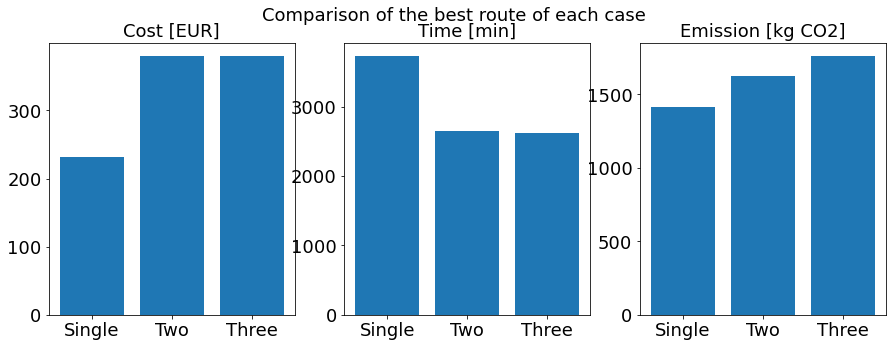

In [11]:
# Histograms of the [seeds] time values for each sample size

BIGGER_SIZE = 18
plt.rc('axes',  labelsize=BIGGER_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('axes',  titlesize=BIGGER_SIZE)

fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=False)

axs[0].bar(height=[best_fit1[0],best_fit2[0],best_fit3[0]], 
           x=['Single','Two','Three'])

axs[1].bar(height=[best_fit1[1],best_fit2[1],best_fit3[1]], 
           x=['Single','Two','Three'])

axs[2].bar(height=[best_fit1[2],best_fit2[2],best_fit3[2]], 
           x=['Single','Two','Three'])

axs[0].set_title('Cost [EUR]')
axs[1].set_title('Time [min]')
axs[2].set_title('Emission [kg CO2]')
    
fig.suptitle('Comparison of the best route of each case', fontsize=BIGGER_SIZE)

plt.show()

In [12]:
# Query longitude and latitude of the cities
route_str = []
for i in range(len(current_route)):
    route_str.append(city_names[current_route[i]])

geolocator = Nominatim(user_agent="myapp")
lat_list = []
lon_list = []
for i in range(len(route_str)):
    location = geolocator.geocode(route_str[i])
    lat_list.append(location.latitude)
    lon_list.append(location.longitude)
    
df_coord = pd.DataFrame(columns=['city','lon','lat'])
df_coord['city'] = route_str
df_coord['lon']  = lon_list
df_coord['lat']  = lat_list
df_coord.head()

,city,lon,lat
0,Amsterdam,4.897976,52.374540
1,Copenhagen,12.570072,55.686724
2,Warsaw,21.006725,52.231958
3,Vienna,16.372504,48.208354
4,Rome,12.482932,41.893320


In [13]:
# Plot the route
import plotly.graph_objects as go
fig = go.Figure()

# If bus then add a green line, if flight then add red line
for i in range(len(df_coord)-1):
    if current_borf[i] == 'B':
        fig.add_trace(go.Scattergeo(
                lon = [df_coord['lon'][i],df_coord['lon'][i+1]],
                lat = [df_coord['lat'][i],df_coord['lat'][i+1]],
                name = "Bus: " + df_coord['city'][i] + "-" + df_coord['city'][i+1],
                mode = 'markers+lines',
                text = df_coord['city'][i],
                line = go.scattergeo.Line(
                            color = 'green',
                            width = 3)))

    elif current_borf[i] == 'F':
        fig.add_trace(go.Scattergeo(
                lon = [df_coord['lon'][i],df_coord['lon'][i+1]],
                lat = [df_coord['lat'][i],df_coord['lat'][i+1]],
                name = "Flight: " + df_coord['city'][i] + "-" + df_coord['city'][i+1],
                mode = 'markers+lines',
                text = df_coord['city'][i],
                line = go.scattergeo.Line(
                           color = 'red',
                           width = 3)))

# Set the map layout to Europe        
fig.update_layout(geo_scope='europe')

# Add city names to the plot
fig.add_trace(go.Scattergeo(
                lon = df_coord['lon'],
                lat = df_coord['lat'],
                text = df_coord['city'],
                mode = 'text',
                showlegend = False))

fig.show()


## 3.6 Explorative Data analysis

In [14]:
print("mean cost NSGA-II =",round(np.mean(df_result_NSGAII['cost']),2))
print("mean cost MOEA/D =",round(np.mean(df_result_MOEAD['cost']),2))
print("mean cost IBEA =",round(np.mean(df_result_IBEA['cost']),2))

print("mean time NSGA-II =",round(np.mean(df_result_NSGAII['time']),2))
print("mean time MOEA/D =",round(np.mean(df_result_MOEAD['time']),2))
print("mean time IBEA =",round(np.mean(df_result_IBEA['time']),2))

print("mean time NSGA-II =",round(np.mean(df_result_NSGAII['carbon']),2))
print("mean time MOEA/D =",round(np.mean(df_result_MOEAD['carbon']),2))
print("mean time IBEA =",round(np.mean(df_result_IBEA['carbon']),2))

mean cost NSGA-II = 380.22
mean cost MOEA/D = 356.64
mean cost IBEA = 382.11
mean time NSGA-II = 3369.97
mean time MOEA/D = 2375.0
mean time IBEA = 2219.93
mean time NSGA-II = 571.3
mean time MOEA/D = 742.31
mean time IBEA = 632.98


In [15]:
fig, ax = plt.subplot(3,1)

ValueError: Illegal argument(s) to subplot: (3, 1)

<Figure size 432x288 with 0 Axes>

# 4. Experimenter
The experimenter in the Platypus framework allows the user to compare multiple algorithms or algorithm settings. Several performance metrics are included in the framework. Here, I focused on the hypervolume indicator. The larger the hypervolume the better the performance.

Please note, that the following code will again run for 30 seeds and 10.000 function evaluations which will also take approximately 30 minutes depending on your computer's performance.

In [16]:
# Load the hyp_result variable from the hard disk
hyp_result = pickle.load(open("hyp_result_3obj_MOTSP12.p","rb"))
display(hyp_result, ndigits=3)

NSGAII
    Problem
        Hypervolume : [0.626, 0.641, 0.639, 0.647, 0.637, 0.654, 0.637, 0.632, 0.649, 0.641, 0.64, 0.633, 0.658, 0.652, 0.651, 0.642, 0.635, 0.641, 0.643, 0.647, 0.64, 0.618, 0.644, 0.633, 0.65, 0.636, 0.644, 0.63, 0.648, 0.628]
MOEAD
    Problem
        Hypervolume : [0.629, 0.621, 0.606, 0.606, 0.643, 0.585, 0.625, 0.615, 0.603, 0.627, 0.607, 0.634, 0.628, 0.63, 0.625, 0.58, 0.611, 0.639, 0.615, 0.635, 0.614, 0.636, 0.606, 0.636, 0.596, 0.624, 0.595, 0.597, 0.643, 0.611]
IBEA
    Problem
        Hypervolume : [0.63, 0.634, 0.63, 0.633, 0.639, 0.612, 0.599, 0.606, 0.596, 0.623, 0.637, 0.63, 0.64, 0.593, 0.631, 0.623, 0.635, 0.635, 0.627, 0.622, 0.63, 0.621, 0.636, 0.624, 0.634, 0.616, 0.642, 0.636, 0.616, 0.603]


## 4.1 Run the experimenter (skip)

In [ ]:
# Skip
city_list = list(np.arange(1,12))
print(city_list)

problem = Problem(nvars=2, nobjs=3)
problem.types[0:] = Permutation(city_list)
problem.types[1:] = Binary(len(city_list)+1)
problem.directions[:] = Problem.MINIMIZE
problem.function = two_opt

algo_list = [NSGAII, MOEAD, IBEA]

# Wird die offspring_size auch automatisch angepasst, wenn ich pop_size verändere?

if __name__ == "__main__":
    algorithms = [(NSGAII, {"variator": PMX()}),
                  (MOEAD,  {"variator": PMX()}),
                  (IBEA,   {"variator": PMX()})]
    
    # run the experiment
    # seeds determines how many times the same algorithm is run (= sample size) 
    results = experiment(algorithms, problem, seeds=30, nfe=10000)

    # calculate the hypervolume indicator 
    hyp = Hypervolume(minimum=[0,0,0],maximum=[10000,10000,10000])
    hyp_result = calculate(results, hyp)
    display(hyp_result, ndigits=3)

In [36]:
# Skip
# Store the result variables on the harddisk
import pickle
pickle.dump(hyp_result, open("hyp_result_3obj_MOTSP12.p", "wb"))

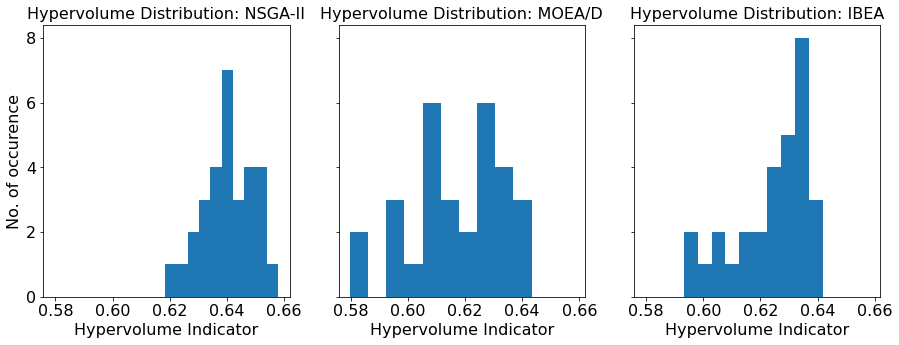

In [18]:
# Histograms of the hypervolume indicators of all three algorithms
BIGGER_SIZE = 16
plt.rc('axes',  labelsize=BIGGER_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('axes',  titlesize=BIGGER_SIZE)

fig, axs = plt.subplots(1,3,figsize=(15,5),sharex=True, sharey=True)

axs[0].hist(x = hyp_result['NSGAII']['Problem']['Hypervolume'])
axs[0].set_title('Hypervolume Distribution: NSGA-II')
axs[0].set(ylabel='No. of occurence')

axs[1].hist(x = hyp_result['MOEAD']['Problem']['Hypervolume'])
axs[1].set_title('Hypervolume Distribution: MOEA/D')

axs[2].hist(x = hyp_result['IBEA']['Problem']['Hypervolume'])
axs[2].set_title('Hypervolume Distribution: IBEA')

for ax in axs.flat:
    ax.set(xlabel='Hypervolume Indicator')
    
plt.show()

[0.6404815960102831, 0.6173279728146698, 0.6244599344171237]


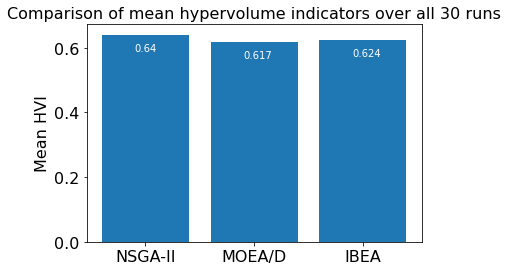

In [19]:
# Compare the mean hypervolume indicator over all 30 runs

hyp_NSGAII  = hyp_result['NSGAII']['Problem']['Hypervolume']
hyp_MOEAD   = hyp_result['MOEAD']['Problem']['Hypervolume']
hyp_IBEA    = hyp_result['IBEA']['Problem']['Hypervolume']

mean_hyp = [np.mean(hyp_NSGAII), np.mean(hyp_MOEAD), np.mean(hyp_IBEA)]
print(mean_hyp)

plt.bar(x=['NSGA-II','MOEA/D','IBEA'], height=mean_hyp)

# Display the values on each bar
for index, value in enumerate(mean_hyp):
    plt.text(index-0.1, value-0.05, str(round(value,3)), color='white')

plt.title('Comparison of mean hypervolume indicators over all 30 runs')
plt.ylabel('Mean HVI')
plt.show()

## 4.2 Wilcoxon Signed-Rank Test

In [20]:
# Wilcoxon signed-rank test
# The Wilcoxon Signed Rank Test is a non-parametric test for comparing two paired (dependent) data sets. 
# It is an alternative to Students Paired t-Test and is used when one or more of the data sets is 
# not normally distributed, and sometimes when sample siz is small.
# Tests whether the central tendencies of two dependent samples are different

test1 = stats.wilcoxon(hyp_NSGAII, hyp_MOEAD)
test2 = stats.wilcoxon(hyp_NSGAII, hyp_IBEA)
test3 = stats.wilcoxon(hyp_MOEAD, hyp_IBEA)

print("NSGAII vs MOEAD",test1)
print("NSGAII vs IBEA ", test2)
print("MOEAD vs IBEA  ",  test3)

# NSGAII vs MOEAD: Significant difference
# NSGAII vs IBEA: Significant difference
# MOEAD vs IBEA: Significant difference

NSGAII vs MOEAD WilcoxonResult(statistic=27.0, pvalue=2.370447702550485e-05)
NSGAII vs IBEA  WilcoxonResult(statistic=22.0, pvalue=1.493563929839868e-05)
MOEAD vs IBEA   WilcoxonResult(statistic=157.0, pvalue=0.12044472790832522)


## 4.3 Sample Size
The lower the standard error of the mean (SEM) the higher the level of confidence.

In [21]:
from scipy import stats
SEM = []
for sample_size in range(3,len(hyp_NSGAII)):
    SEM.append(stats.sem(hyp_NSGAII[0:sample_size]))
    
fig = go.Figure(
    data=go.Scatter(x=list(range(3,len(hyp_NSGAII))), 
                    y=SEM),
    layout=dict(xaxis=dict(title='Sample Size'),
                yaxis=dict(title='Standard Error of the Mean'),
                title='Standard Error of the Mean for different Sample Sizes'))
fig.show()
# Result: The SEM is very low (<0.05) and thus the sample size of 30 should be sufficient.